In [1]:
import os
import glob
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# See github.com/timesler/facenet-pytorch:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on device: cpu


In [2]:
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

# Load facial recognition model
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

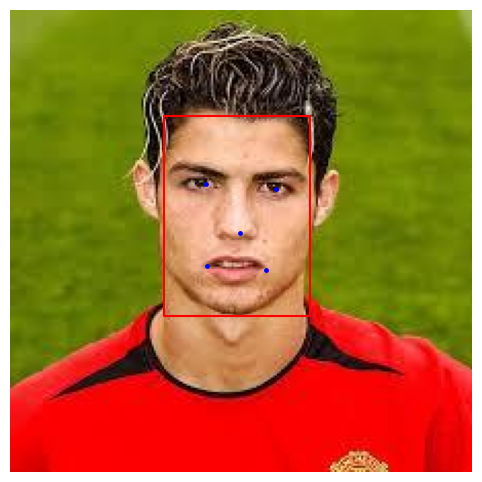

In [3]:
# Load ảnh
image = Image.open('./Ronaldo/1.jpg')  # Thay đường dẫn ảnh ở đây

# Phát hiện khuôn mặt và landmarks
boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)

# Hiển thị kết quả
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')

# Vẽ bounding boxes và landmarks
if boxes is not None:
    for box, landmark in zip(boxes, landmarks):
        # Vẽ khung
        x0, y0, x1, y1 = box
        plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], color='r')
        # Vẽ landmark
        plt.scatter(landmark[:, 0], landmark[:, 1], s=6, c='blue')

plt.show()

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mtcnn = MTCNN(keep_all=False, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [5]:
# Hàm trích xuất embeddings
def extract_embeddings(image_path):
    img = Image.open(image_path)
    img_cropped = mtcnn(img)
    if img_cropped is None:
        return None
    img_cropped = img_cropped.unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = resnet(img_cropped).cpu().numpy()
    return embedding.flatten()

In [6]:
# Hàm load dataset
def load_dataset(dataset_path):
    embeddings = []
    labels = []
    for person_name in os.listdir(dataset_path):
        person_dir = os.path.join(dataset_path, person_name)
        if not os.path.isdir(person_dir):
            continue
        for image_name in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_name)
            embedding = extract_embeddings(image_path)
            if embedding is not None:
                embeddings.append(embedding)
                labels.append(person_name)
    return np.array(embeddings), np.array(labels)

In [7]:
# Hàm dự đoán với kiểm tra "unknown"
def predict_face(knn, image_path, threshold=0.7):
    embedding = extract_embeddings(image_path)
    if embedding is None:
        return "No face detected"
    distances, indices = knn.kneighbors([embedding])
    min_distance = distances[0][0]
    print(f"Min distance: {min_distance}")
    if min_distance <= threshold:
        prediction = knn.predict([embedding])[0]
        return prediction
    else:
        return "unknown"

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

dataset_path = '.'
X, y = load_dataset(dataset_path)

In [9]:
print(f"X: {X}, SHAPE: {X.shape}")
print(f"y: {y}, SHAPE: {y.shape}")

X: [[ 0.02848321  0.03255691 -0.02608038 ... -0.03974489  0.02523384
  -0.00492489]
 [ 0.04927551  0.03258889 -0.01056933 ... -0.02375884 -0.00356662
  -0.00353969]
 [ 0.04182051  0.03301068 -0.02197198 ... -0.04178743  0.00957329
   0.00749272]
 ...
 [ 0.1175331  -0.0302982   0.0169185  ...  0.01482349 -0.03143261
  -0.02637295]
 [ 0.09332146  0.00215603 -0.00543168 ... -0.0242268  -0.00541789
  -0.03279609]
 [ 0.07317274  0.02209464  0.01013742 ... -0.00500076  0.01801433
  -0.03698747]], SHAPE: (56, 512)
y: ['Hiep' 'Hiep' 'Hiep' 'Hiep' 'Hiep' 'Hiep' 'Hiep' 'Hiep' 'Hiep' 'Hiep'
 'Hieu' 'Hieu' 'Hieu' 'Hieu' 'Hieu' 'Hieu' 'Hieu' 'Hieu' 'Hieu' 'Hieu'
 'Ishikawa' 'Ishikawa' 'Ishikawa' 'Ishikawa' 'Lam' 'Lam' 'Lam' 'Lam' 'Lam'
 'Lam' 'Lam' 'Lam' 'Lam' 'Lam' 'Nishida' 'Nishida' 'Nishida' 'Nishida'
 'Onodera' 'Onodera' 'Onodera' 'Ran' 'Ran' 'Ran' 'Ronaldo' 'Ronaldo'
 'Ronaldo' 'Ronaldo' 'Ronaldo' 'Ronaldo' 'Ronaldo' 'Ronaldo' 'Ronaldo'
 'Sekita' 'Sekita' 'Sekita'], SHAPE: (56,)


In [10]:
n_neighbors_list = [5, 7, 11, 13, 15]
cv_scores = []

for n in n_neighbors_list:
    knn = KNeighborsClassifier(n_neighbors=n, metric='euclidean')
    # Sử dụng 5-fold cross-validation
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
    print(f'n_neighbors={n}: Mean CV Accuracy={scores.mean():.4f} (+/- {scores.std():.4f})')

# Tìm n_neighbors tốt nhất
best_n = n_neighbors_list[np.argmax(cv_scores)]
print(f'Best n_neighbors: {best_n} with CV Accuracy: {max(cv_scores):.4f}')

knn = KNeighborsClassifier(n_neighbors=best_n, metric='euclidean')
knn.fit(X, y)

C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


n_neighbors=5: Mean CV Accuracy=0.8394 (+/- 0.0675)
n_neighbors=7: Mean CV Accuracy=0.8212 (+/- 0.0578)
n_neighbors=11: Mean CV Accuracy=0.6970 (+/- 0.0383)
n_neighbors=13: Mean CV Accuracy=0.6970 (+/- 0.0383)
n_neighbors=15: Mean CV Accuracy=0.6970 (+/- 0.0383)
Best n_neighbors: 5 with CV Accuracy: 0.8394


C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


KNeighborsClassifier(metric='euclidean')

In [11]:
from sklearn.svm import SVC

C_list = [0.1, 1, 10, 100]
kernels = ['linear', 'rbf']
cv_scores = []

for kernel in kernels:
    for C in C_list:
        svm = SVC(kernel=kernel, C=C)
        # Sử dụng 5-fold cross-validation
        scores = cross_val_score(svm, X, y, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        print(f'kernel={kernel}, C={C}: Mean CV Accuracy={scores.mean():.4f} (+/- {scores.std():.4f})')

# Tìm kernel và C tốt nhất
best_params = np.argmax(cv_scores)
best_kernel = kernels[best_params // len(C_list)]
best_C = C_list[best_params % len(C_list)]
print(f'Best kernel: {best_kernel}, Best C: {best_C} with CV Accuracy: {max(cv_scores):.4f}')

kernel=linear, C=0.1: Mean CV Accuracy=0.6970 (+/- 0.0383)


C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


kernel=linear, C=1: Mean CV Accuracy=1.0000 (+/- 0.0000)
kernel=linear, C=10: Mean CV Accuracy=1.0000 (+/- 0.0000)
kernel=linear, C=100: Mean CV Accuracy=1.0000 (+/- 0.0000)
kernel=rbf, C=0.1: Mean CV Accuracy=0.5545 (+/- 0.0445)
kernel=rbf, C=1: Mean CV Accuracy=1.0000 (+/- 0.0000)
kernel=rbf, C=10: Mean CV Accuracy=1.0000 (+/- 0.0000)
kernel=rbf, C=100: Mean CV Accuracy=1.0000 (+/- 0.0000)
Best kernel: linear, Best C: 1 with CV Accuracy: 1.0000


C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated

In [12]:
svc = SVC(kernel=best_kernel, C=best_C)
svc.fit(X, y)

SVC(C=1, kernel='linear')

In [19]:
from joblib import dump, load
model = load(open('./knn_model.pkl', 'rb'))
model

KNeighborsClassifier(metric='euclidean')

In [20]:
test_images = './8.jpg'
test_embeddings = extract_embeddings(test_images)
predict = model.predict([test_embeddings])
print(f'Predicted: {predict[0]}')

Predicted: NV001
